In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from openretina.dataloaders import get_movie_dataloader
from openretina.hoefling_2022_data_io import gen_start_indices, natmov_dataloaders_v2
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout
from openretina.misc import (
    CustomPrettyPrinter,
    load_dataset_from_h5,
    print_h5_structure,
)

%load_ext autoreload
%autoreload 2

In [2]:
# base_folder = Path("~/PhD_data").expanduser()
base_folder = Path("/Data/")
data_path = os.path.join(base_folder, "fd_export/2024-01-11_neuron_data_stim_8c18928_responses_99c71a0.pkl")
movies_path = os.path.join(base_folder, "fd_export/2024-01-11_movies_dict_8c18928.pkl")
old_movies_path = os.path.join(base_folder, "fd_export/movies_8c18928.pkl")

In [3]:
data = pickle.load(open(data_path, "rb"))
movies = pickle.load(open(movies_path, "rb"))

old_movies = pickle.load(open(old_movies_path, "rb"))

In [4]:
pp = CustomPrettyPrinter(indent=4)
pp.pprint(data)
pp.pprint(movies)

{   '1_ventral1_20210929': {   'eye': 'left',
                               'group_assignment': numpy.ndarray(shape=(86,)),
                               'key': {   'date': '2021-09-29',
                                          'exp_num': 1,
                                          'experimenter': 'Szatko',
                                          'field_id': 1,
                                          'stim_id': 5},
                               'responses_final': numpy.ndarray(shape=(86, 18450)),
                               'roi_coords': torch.Tensor(shape=[86, 2]),
                               'roi_ids': numpy.ndarray(shape=(86,)),
                               'scan_sequence_idx': 8,
                               'stim_id': 5,
                               'traces': numpy.ndarray(shape=(104,)),
                               'tracestimes': numpy.ndarray(shape=(104,))},
    '1_ventral1_20210930': {   'eye': 'left',
                               'group_assignment': nu

---

In [5]:
baccus_data_example_path = os.path.join(
    base_folder,
    "baccus_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5",
)

In [6]:
print_h5_structure(baccus_data_example_path)

{'spikes': {'cell01': 'h5.Dataset(shape=(43927,)), float64',
            'cell02': 'h5.Dataset(shape=(11819,)), float64',
            'cell03': 'h5.Dataset(shape=(12423,)), float64',
            'cell04': 'h5.Dataset(shape=(37662,)), float64',
            'cell05': 'h5.Dataset(shape=(10976,)), float64',
            'cell06': 'h5.Dataset(shape=(11654,)), float64',
            'cell07': 'h5.Dataset(shape=(17792,)), float64',
            'cell08': 'h5.Dataset(shape=(4566,)), float64',
            'cell09': 'h5.Dataset(shape=(36307,)), float64'},
 'test': {'repeats': {'cell01': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell02': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell03': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell04': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell05': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell06': 'h5.Dataset(shape=(5, 5997)), float64',
                   

In [7]:
train_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/train/stimulus")
test_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/test/stimulus")

In [8]:
train_video_baccus = train_video_baccus[None, :]
train_video_baccus.shape

(1, 359802, 50, 50)

Regarding the stimuli used:

    A video monitor projected the visual stimuli at 30 Hz controlled by Matlab (Mathworks), using Psychophysics Toolbox.54 Stimuli had a constant mean intensity of 10 mW/m2. Images were presented in a 50 x 50 grid with a square size of 50 mm. Static natural jittered scenes consisted of images drawn from a natural image database.55 To create images for presentation to the retina, original color images were converted to grayscale, and were scaled to have minimum and maximum pixel intensities that matched that of the monitor. Pixel regions of 50 x 50 size were then selected from each image at a random location without spatial averaging for presentation.
    
So it is natural images, not videos. Also, regarding stimulus presentation:

    The image also abruptly changed in a single frame to a different location every one second, representing saccades, although such transitions did not contain a sweeping shift in the image. Transitions occurred both between different locations in the same image and between different images.

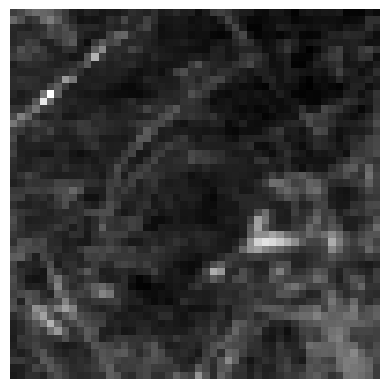

In [9]:
from openretina.plotting import play_stimulus

play_stimulus(torch.Tensor(train_video_baccus[:, :90]))

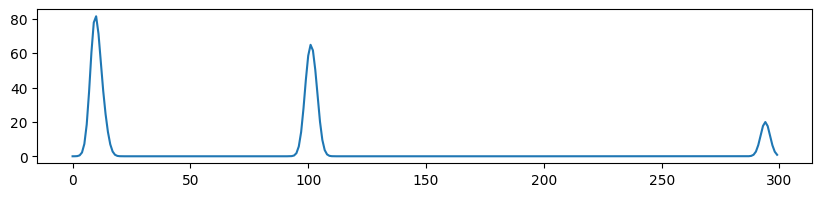

In [10]:
train_response_baccus = load_dataset_from_h5(baccus_data_example_path, "/train/response/firing_rate_20ms")
test_response_baccus = load_dataset_from_h5(baccus_data_example_path, "/test/response/firing_rate_20ms")
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.plot(train_response_baccus[8, :300])

Single "clip" length is 90 frames. (i.e. how long an image was shown for)

Response should be firing rate in Hz, calculated from the ephys trace with various time bins. In the paper they say to train the model "The response and stimulus were binned in 10 ms time bins."

Our response is also a firing rate, but inferred from the calcium trace using c2s. Given that they are using MEAs, the temporal resolution of the signal (and some of the binning they used) is much higher. 

However, we can still use the spikes they provided to get a similar binning to our data.

---
# Sample data input and model training on Salamander data

In [11]:
## gen_start_indices needs to be used if we want to automatically generate validation clips.
movie_length = train_video_baccus.shape[1]
clip_length = 90
# start_indices = gen_start_indices(
#     random_sequences=np.arange(0, movie_length // clip_length)[:, None],
#     val_clip_idx=[1, 2, 30, ],
#     clip_length=clip_length,
#     chunk_size=50,
#     num_clips=len(np.arange(0, movie_length // clip_length)),
# )

In [12]:
sample_dataloader = get_movie_dataloader(
    train_video_baccus,
    train_response_baccus.T,  # Transpose the response to match the dataloader format
    roi_ids=np.arange(train_response_baccus.shape[0]),
    roi_coords=np.random.normal(0, 1, (train_response_baccus.shape[0], 2)),
    group_assignment=np.arange(train_response_baccus.shape[0]),
    split="train",
    start_indices=np.arange(0, train_video_baccus.shape[1], 90),
    scan_sequence_idx=None,
    chunk_size=60,
    batch_size=32,
    scene_length=90,
)

In [13]:
baccus_data_dict = {
    "test_session": {
        "responses_final": {
            "train": train_response_baccus,
            "test": test_response_baccus,
        },
        "stim_id": "salamander_natural",
    }
}
baccus_movie_dict = {"train": train_video_baccus, "test": test_video_baccus[None, ...]}

In [14]:
dataloaders = natmov_dataloaders_v2(
    baccus_data_dict,
    baccus_movie_dict,
    train_chunk_size=50,
    batch_size=32,
    clip_length=90,
    num_clips=len(np.arange(0, movie_length // clip_length)),
    num_val_clips=20,
)

---

# Training

In [15]:
from openretina.hoefling_2022_configs import model_config

model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

{'test_session': {'inputs': torch.Size([32, 1, 50, 50, 50]), 'targets': torch.Size([32, 50, 9])}}
Random seed 42 has been set.


/Projects/open-retina/openretina/hoefling_2022_models.py:756: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  mask = STSeparableBatchConv3d.mask_tf(time.T, stretches, T)


In [16]:
from openretina.hoefling_2022_configs import trainer_config
from openretina.training import standard_early_stop_trainer

import wandb

In [17]:
wandb.login()
run = wandb.init(
    project="salamander_data_hoefling_2022_model",
    notes="First tests with mouse architecture on salamander image data.",
    tags=None,
    job_type=None,
    name=None,
)

wandb.config.update({**model_config, **trainer_config})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fede_dagos. Use `wandb login --relogin` to force relogin


In [18]:
test_score, val_score, output, model_state = standard_early_stop_trainer(
    model,
    dataloaders,
    max_epochs=1,
    seed=42,
    device="cuda",
    wandb_logger=run,
    **trainer_config,
)

Random seed 42 has been set.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
val_field = "test_session"
val_sample = next(iter(dataloaders["validation"][val_field]))

input_samples = val_sample.inputs
targets = val_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), val_field)
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()

Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index
Slicing with integer index


In [20]:
targets.shape

(20, 90, 9)

In [21]:
reconstructions.shape

(20, 60, 9)

In [22]:
import seaborn as sns

neuron = 1
fig, axes = plt.subplots(4, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(targets[trace_chunk, 30:, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

wandb.log({"reconstruction": fig})
plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



<Figure size 640x480 with 0 Axes>

In [23]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr,████████████████████▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▅▃▇▆▆▃▃▅▇▁▃▃▄▅▄▆▃▃▅▆▅▃▅▃▄▇▂▅▄▂█▆▃▃▅▄▃▂
val_MSE_loss,█▆▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_corr,▁▅▆▆▇▇▇▇▇▇▆▇▇▇██▇▇▇█████████████████████
val_poisson_loss,█▅▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,41
lr,0.0009
train_loss,-8347.65723
val_MSE_loss,1979.30651
val_corr,0.3725


In [24]:
print(test_score)

0.6235866016811795


In [31]:
test_field = "test_session"
test_sample = next(iter(dataloaders["test"][test_field]))

input_samples = test_sample.inputs
targets = test_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), test_field)
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()

In [35]:
reconstructions.shape

(5966, 9)

In [36]:
targets.shape

(5996, 9)

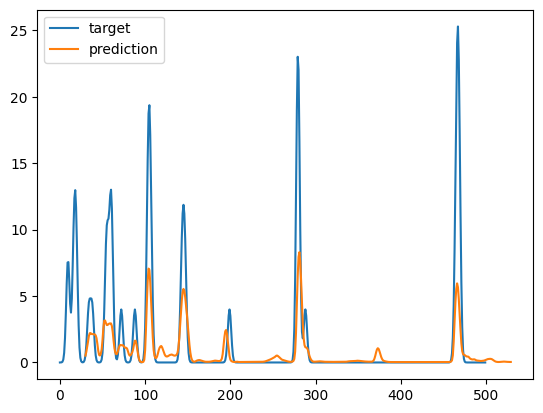

In [39]:
window = 500
neuron = 2
plt.plot(np.arange(0, window), targets[:window, neuron], label="target")
plt.plot(np.arange(30, window + 30), reconstructions[:window, neuron], label="prediction")
plt.legend()